In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

%matplotlib inline

In [2]:
patients_yoko = pd.read_csv('141003_yokohama_covid19_patients.csv')

# 1.前処理

In [3]:
patients_yoko.head()

,No,全国地方自治体コード,都道府県名,市区町村名,公表日,患者_年代,患者_状態,患者_退院済フラグ
0,1,141003,神奈川県,横浜市,2020-02-18,60代,退院,1.0
1,2,141003,神奈川県,横浜市,2020-02-20,60代,退院,1.0
2,3,141003,神奈川県,横浜市,2020-02-21,30代,退院,1.0
3,4,141003,神奈川県,横浜市,2020-02-28,50代,退院,1.0
4,5,141003,神奈川県,横浜市,2020-03-03,20代,退院,1.0


In [4]:
df = patients_yoko.copy()

# 列の削除とrename
df = df.drop(['No', '全国地方自治体コード', '都道府県名', '市区町村名'], axis=1)
df.rename(columns={'公表日':'datetime', '患者_年代':'age', '患者_状態':'status', '患者_退院済フラグ':'flg_discharge'}, inplace=True)

# ageの整形
df.age = df.age.str.replace('代','')
df.age = df.age.str.replace('10歳未満','0')
df.age = df.age.str.replace('幼児','0')
df.age = df.age.str.replace('90歳以上','90')
df.age = df.age.str.replace('非公表','999')
df.age = df.age.str.replace('調査中','999')

# statusの整形
df.status.replace({'退院':'discharge', '死亡':'dead', 'その他':'else', '中等症':'moderate', '軽症':'mild', '無症状':'nothing', '調査中':'else', '重症':'severe'}, inplace=True)

# dateの整形　
df.datetime = pd.to_datetime(df.datetime)
df['date'] = df['datetime'].dt.strftime('%Y%m%d')

# flg_dischargeの整形
df.flg_discharge.fillna(0,inplace=True)

# flg_deadの作成
df['flg_dead'] = 0
df.loc[df['status'] == 'dead','flg_dead'] = 1

# int型へ変換
df[['age','flg_discharge']] = df[['age','flg_discharge']].astype(int)

# statusとageが不明なものを消去
df =df[~(df['age']==999)]
df = df[~(df['status']=='else')]

# column順の整形
df = df[['datetime','date','age','status','flg_discharge','flg_dead']]

df.head()

,datetime,date,age,status,flg_discharge,flg_dead
0,2020-02-18,20200218,60,discharge,1,0
1,2020-02-20,20200220,60,discharge,1,0
2,2020-02-21,20200221,30,discharge,1,0
3,2020-02-28,20200228,50,discharge,1,0
4,2020-03-03,20200303,20,discharge,1,0


# 2.分布

## 2.1.年齢

<AxesSubplot:xlabel='age'>

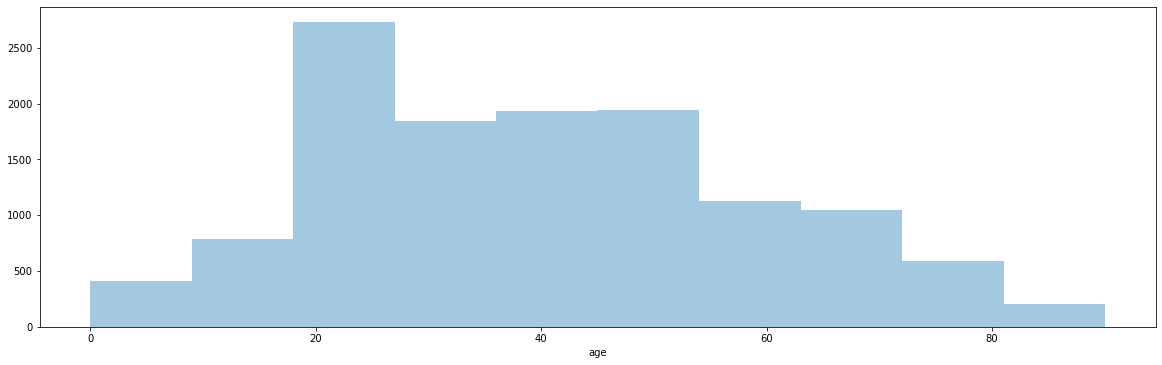

In [5]:
# age ヒストグラム
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
sns.distplot(df['age'], kde=False, rug=False, bins=10)

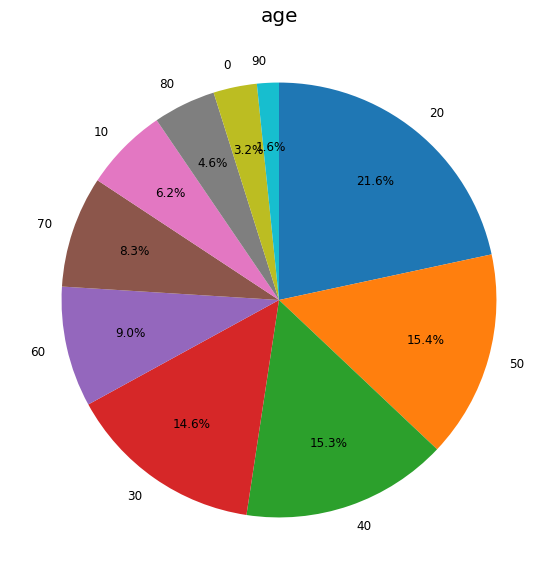

In [6]:
# age 円グラフ
label = list(df["age"].value_counts().index)

plt.figure(figsize=(10,10))
plt.pie(df['age'].value_counts(),
       labels=label, counterclock=False, startangle=90,
       autopct='%1.1f%%', pctdistance=0.7,textprops={'size': 'large'})
plt.title('age', fontsize=20)
plt.show()

#### 20~50代が多く，次いで60，70代

## 2.2.症状（Status）

In [7]:
# 全体のステータス分布　{'退院':"0", '死亡':"5", 'その他':"999", '中等症':"3", '軽症':"2", '無症状':"1", '調査中':"999", '重症':"4"}
df['status'].value_counts(normalize=True)

discharge    0.785312
mild         0.170275
nothing      0.021413
dead         0.012372
moderate     0.008486
severe       0.002141
Name: status, dtype: float64

#### 全体の死亡率は１％であることが分かる

In [8]:
# 年齢別死亡率
df[df['status'] == 'dead'].groupby('age').size()/df.groupby('age').size()

age
0          NaN
10         NaN
20         NaN
30         NaN
40    0.000517
50    0.001029
60    0.010619
70    0.038241
80    0.112628
90    0.170732
dtype: float64

#### 30代以下の死亡率は0％．また，80代から死亡率が上がっていることが分かる

## 症状の割合

In [9]:
df['status'].value_counts(normalize=True) 

discharge    0.785312
mild         0.170275
nothing      0.021413
dead         0.012372
moderate     0.008486
severe       0.002141
Name: status, dtype: float64

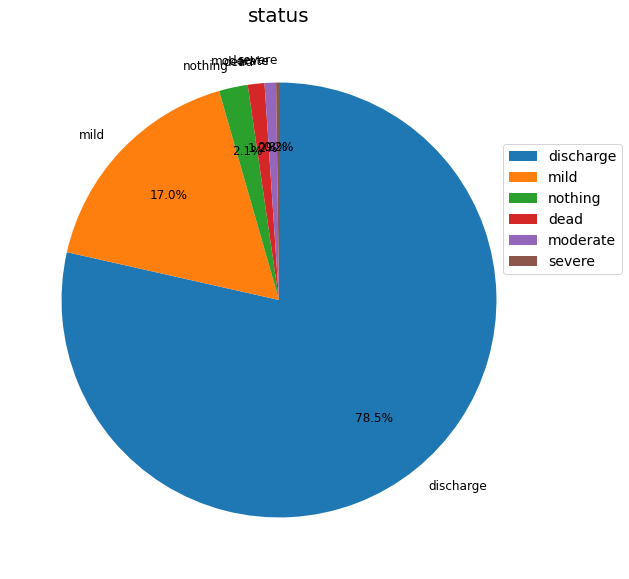

In [10]:
label = df['status'].value_counts().index 


plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.pie(df.status.value_counts(),
        counterclock=False, startangle=90,
       labels=label,autopct='%1.1f%%', pctdistance=0.7,textprops={'size': 'large'})
plt.legend(label, fontsize=14,bbox_to_anchor=(0.9, 0.8)) # (7)凡例の表示
plt.title('status', fontsize=20)
plt.show()

### 退院（discharge）の割合が多いので退院を除外する

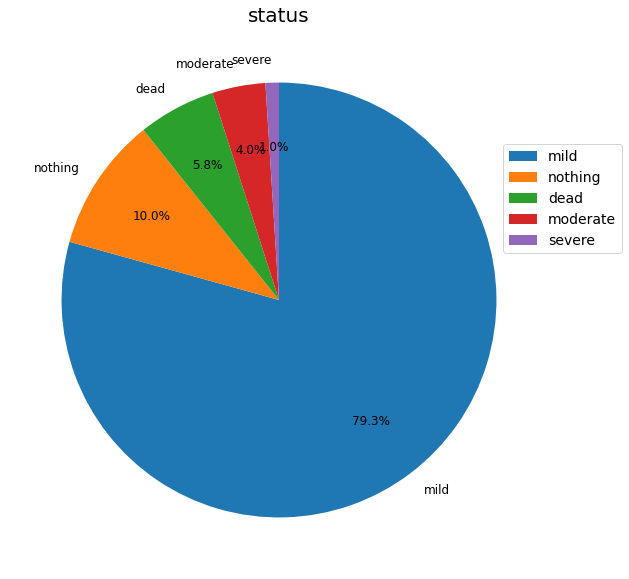

In [11]:
# 退院を除外したstatus
status_df = df[df['status'] != "discharge"]['status']

label = ['mild', 'nothing','dead','moderate','severe']

plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.pie(status_df.value_counts(),
        counterclock=False, startangle=90,
       labels=label,autopct='%1.1f%%', pctdistance=0.7,textprops={'size': 'large'},)
plt.legend(label, fontsize=14,bbox_to_anchor=(0.9, 0.8)) # (7)凡例の表示
plt.title('status',fontsize=20)
plt.show()

### 全体の3/4が軽症（mild），次に多いのが無症状（notihng）．陽性者の約9割は症状が軽い（軽症者の容態が変化する可能性もある）

## 2.3.感染者数の推移

<AxesSubplot:xlabel='datetime', ylabel='Count'>

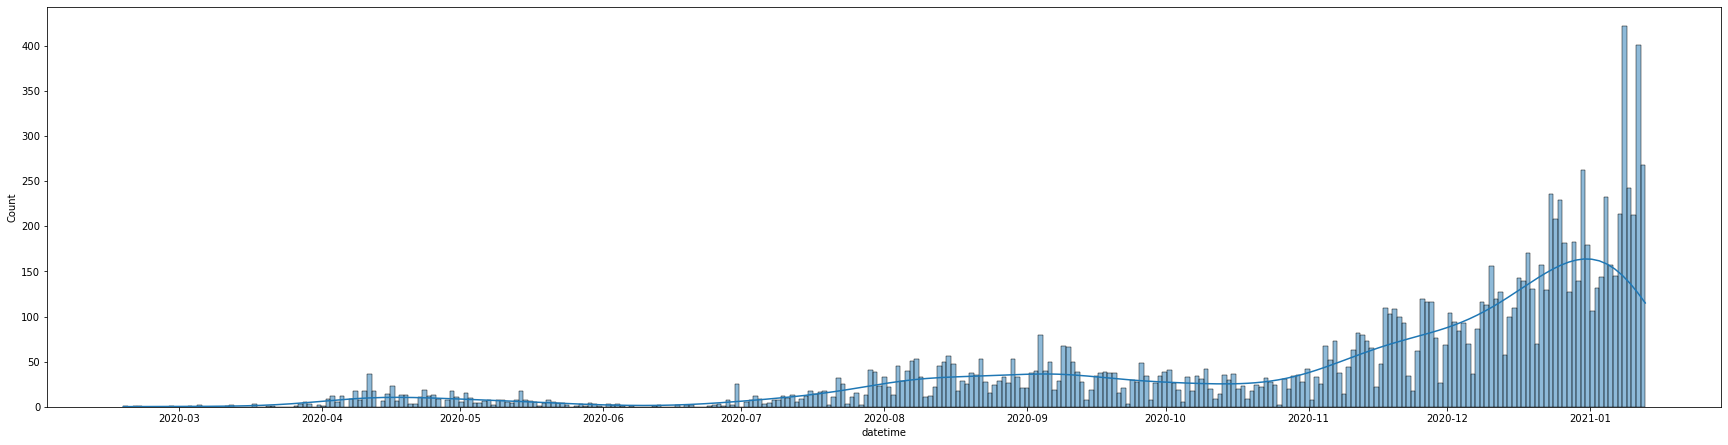

In [12]:
plt.figure(figsize=(30,25))
plt.subplot(3,1,1)
# sns.distplot(df['age'], kde=False, rug=False, bins=10)
bins_max=df["datetime"].max()-df["datetime"].min()
bins_max=bins_max.days+1
sns.histplot(df["datetime"],bins=bins_max, kde=True)

### 感染者数推移（11/01~1/13）

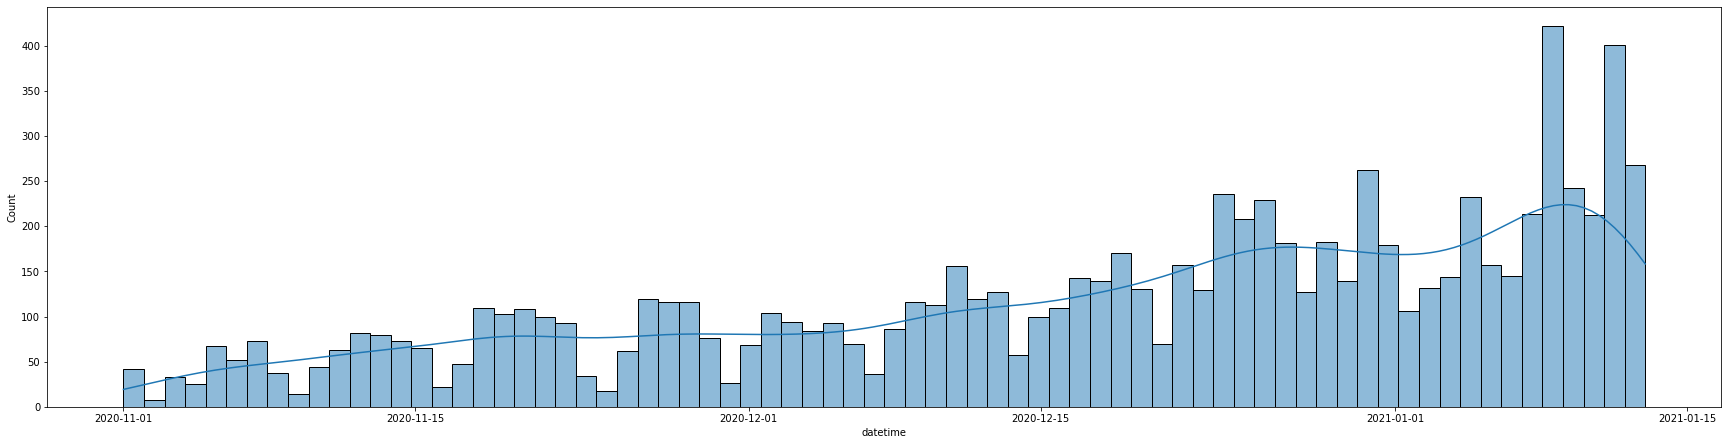

In [13]:
df_2011to2101 = df[df["date"] >= "20201101"]

plt.figure(figsize=(30,25))
plt.subplot(3,1,1)
# sns.distplot(df['age'], kde=False, rug=False, bins=10)
bins_max=df_2011to2101["datetime"].max()-df_2011to2101["datetime"].min()
bins_max=bins_max.days+1
sns.histplot(df_2011to2101["datetime"],bins=bins_max, kde=True)
plt.show()

#### 増加率を分かりやすくするため対数グラフをとる

In [14]:
# 一週間ごとに集計（11月~1月）
df_temp = df_2011to2101.set_index('datetime')
df_2011to2101 = df_temp.resample('W').mean()
df_2011to2101 = pd.concat([df_2011to2101,df_temp.resample('W').size()],axis=1)
df_2011to2101.columns=['age','flg_discharge','flg_dead','number_of_cases']
df_2011to2101 = df_2011to2101.reset_index()
df_2011to2101['date'] = df_2011to2101['datetime'].dt.strftime('%Y%m%d')

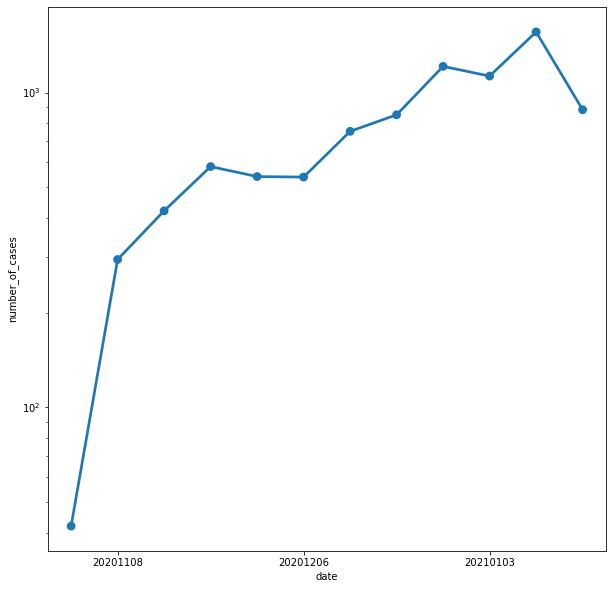

In [15]:
# 対数グラフの描写
plt.figure(figsize=(10,10))
# plt.subplot(3,1,1)
ax = plt.gca()
ax.set_yscale('log')
ax = sns.pointplot(x='date', y='number_of_cases', data=df_2011to2101)

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%4!=1:
        xticks[i].set_visible(False)

plt.show()

#### 12月までの増加率は高い．12月中旬からも依然として増加傾向にある

## 2.4.死亡率の推移

In [16]:
# 一週間ごとに集計
df2 = df.set_index('datetime')
df_week = df2.resample('W').mean()
df_week = pd.concat([df_week,df2.resample('W').size()],axis=1)
df_week.columns=['age','flg_discharge','flg_dead','number_of_cases']
df_week = df_week.reset_index()
df_week['date'] = df_week['datetime'].dt.strftime('%Y%m%d')

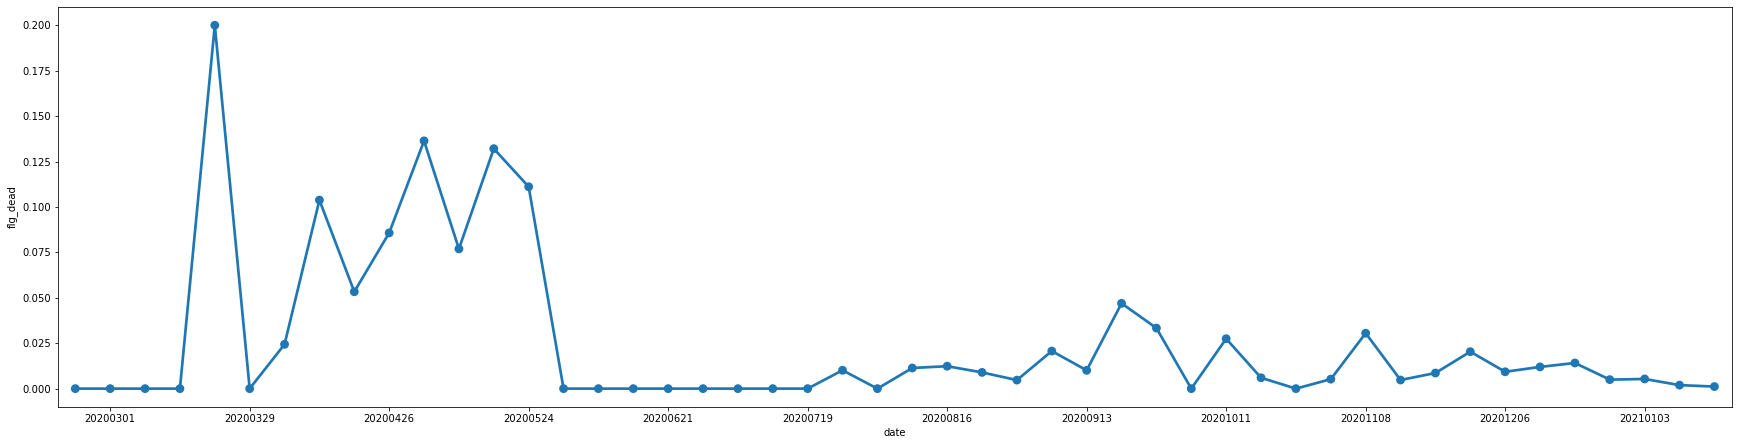

In [17]:
# 死亡率の描画
plt.figure(figsize=(30,25))
plt.subplot(3,1,1)
ax = sns.pointplot(x='date', y='flg_dead', data=df_week)

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%4!=1:
        xticks[i].set_visible(False)

plt.show()

#### 感染者数は増加しているが直近の死亡率に大きな変化はなし．このデータからは医療崩壊の兆候が見られない

## 2.5.年齢別症状

#### 無症状の若い年齢層が感染を広めているということに関しての分析

In [18]:
# 一月以降のデータを使用
df_2101 = df[df["date"] >= "20210101"]
# 年齢ごとに集計
df_status_by_age = pd.crosstab(df_2101['status'], df_2101['age'], normalize=True)
# 無症状の割合をソート
df_nothing_by_age = df_status_by_age.iloc[df_status_by_age.index.get_loc('nothing')].sort_values(ascending=False)
df_nothing_by_age = df_nothing_by_age.reset_index()
df_nothing_by_age['age'] = df_nothing_by_age['age'].astype(str)

<AxesSubplot:xlabel='age', ylabel='nothing'>

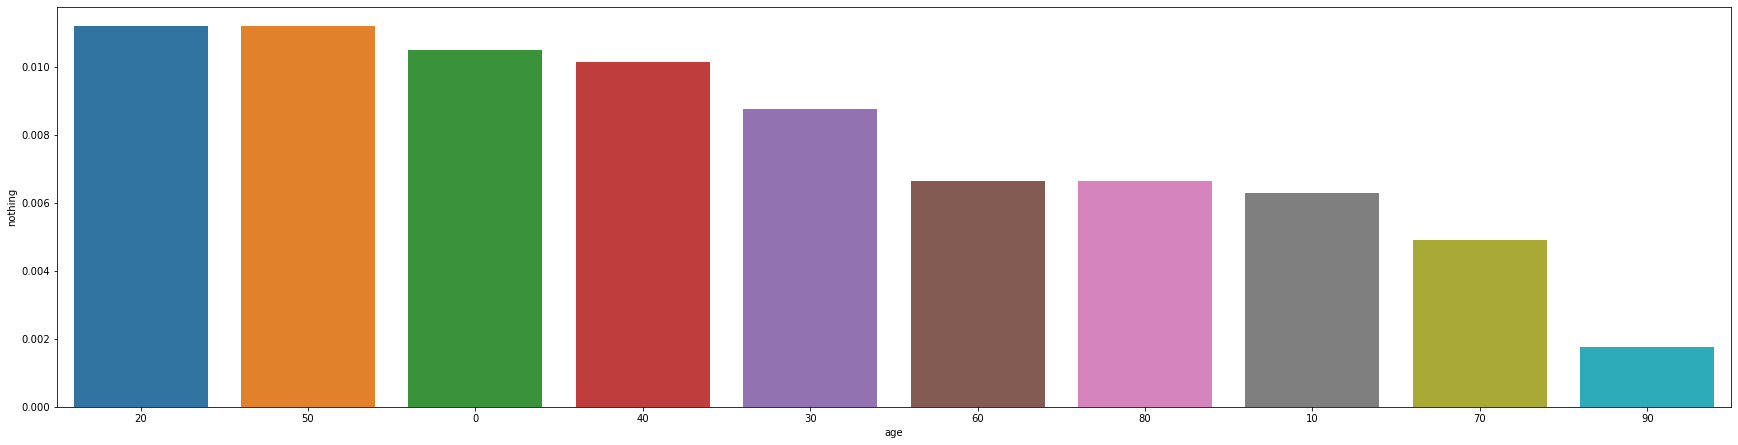

In [19]:
plt.figure(figsize=(30,25))
plt.subplot(3,1,1)
sns.barplot(data=df_nothing_by_age,x='age',y='nothing')

#### 無症状者は20~50代に多いことから，若者に限らずこれらの年齢層が感染を広めている可能性が高い

### 年齢別円グラフ

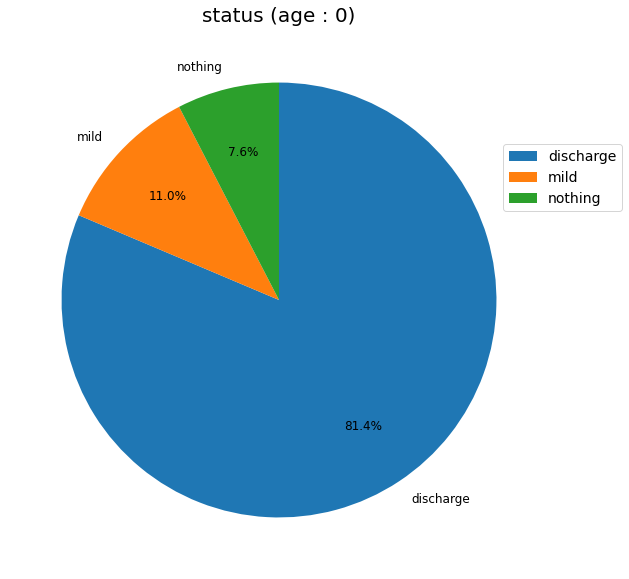

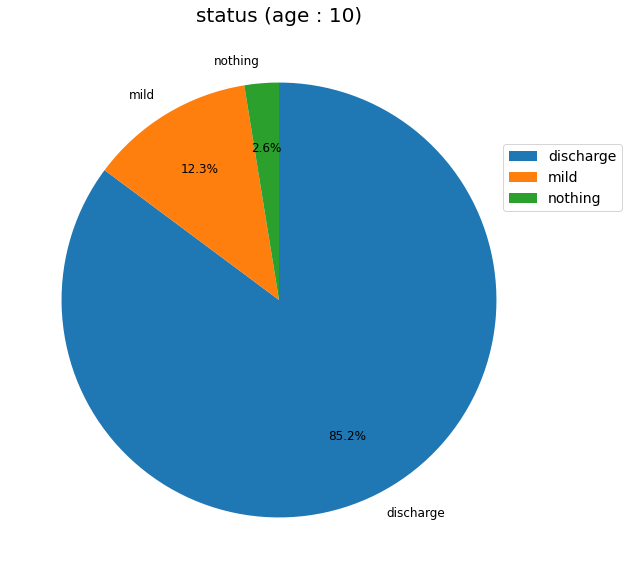

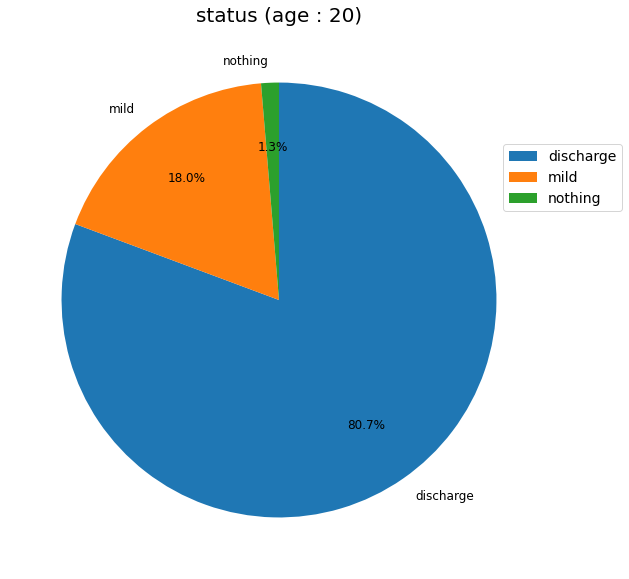

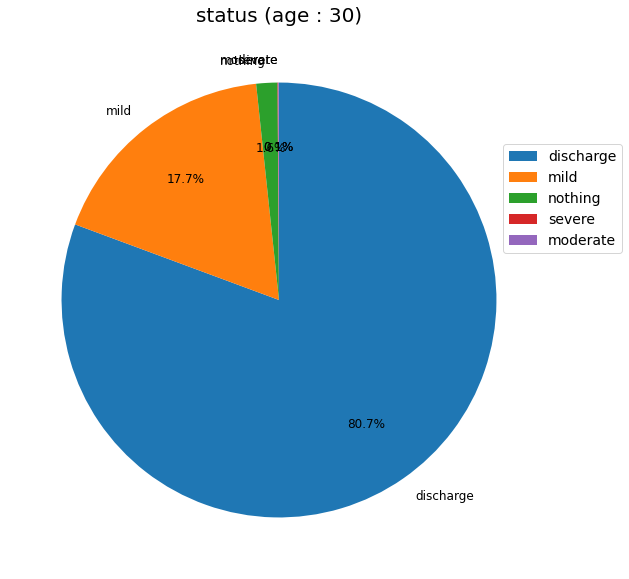

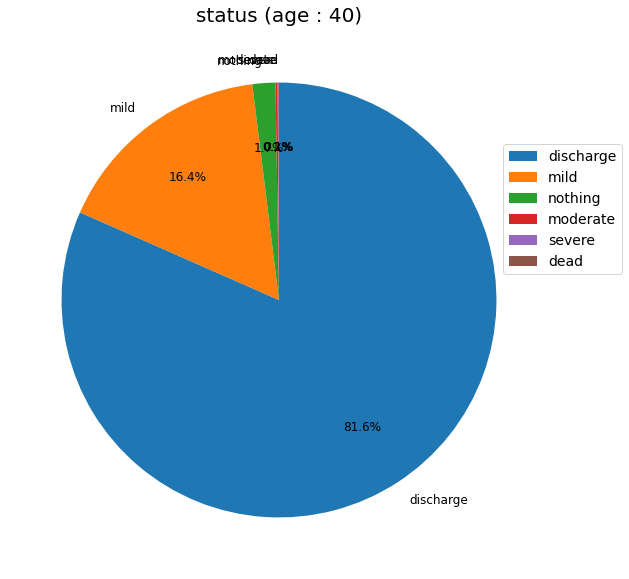

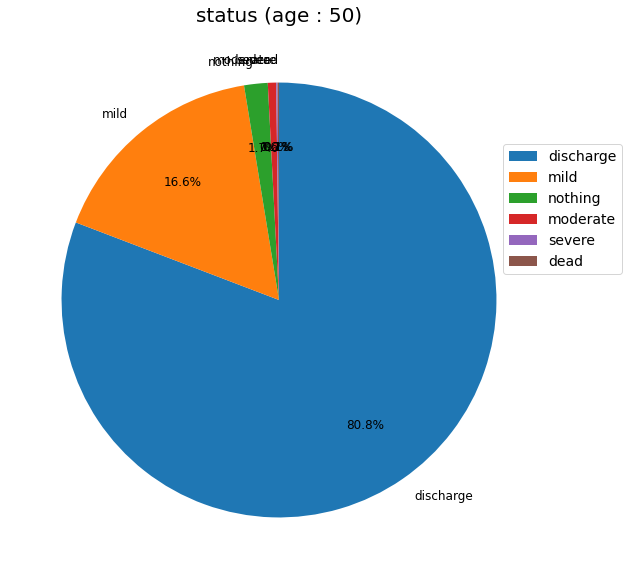

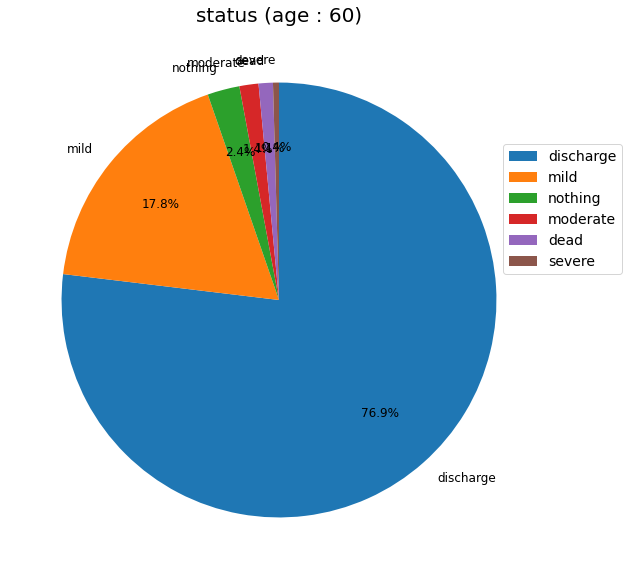

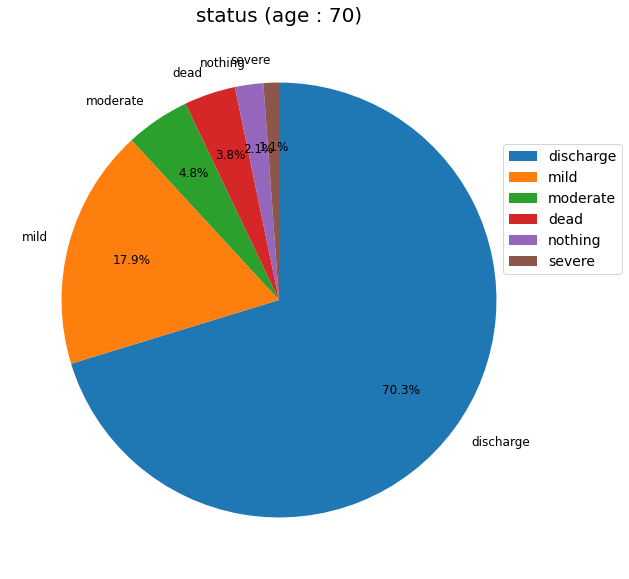

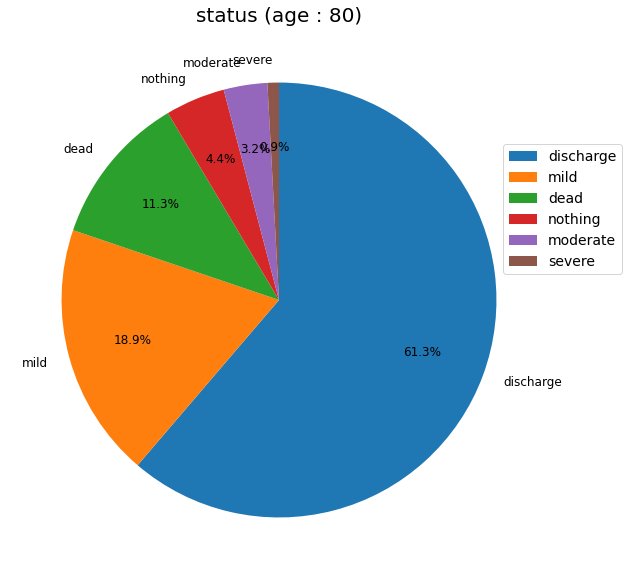

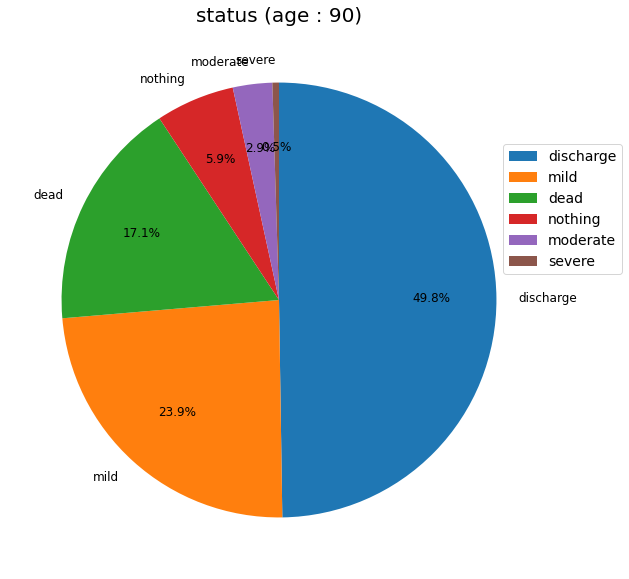

In [20]:
for i in df.age.sort_values().unique():
    df_by_age = df[df["age"] == i]

    label = list(df_by_age.status.value_counts().index)
    plt.figure(figsize=(10,10))
    plt.rcParams['font.size'] = 10
    plt.pie(df_by_age.status.value_counts(),
            counterclock=False, startangle=90,
        labels=label,autopct='%1.1f%%', pctdistance=0.7,textprops={'size': 'large'})
    plt.legend(label, fontsize=14,bbox_to_anchor=(0.9, 0.8)) # (7)凡例の表示
    plt.title('status (age : '+ str(i)+')', fontsize=20)
    plt.show()